In [ ]:
# default_exp core

# module occlusion_exp
> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
import fastai
import torch
import torchvision
from fastai.vision.all import *
from datetime import datetime
from jupyterthemes import jtplot
jtplot.style(theme='onedork')

In [ ]:
from occlusion_exp.utils import *

In [ ]:
state_versions(['fastai', 'fastcore', 'torch', 'torchvision'])

Below are the versions of `fastai`, `fastcore`, `torch`, and `torchvision` currently running at the time of writing this:
* `fastai`: 2.3.1 
* `fastcore`: 1.3.19 
* `torch`: 1.7.1 
* `torchvision`: 0.8.2 
---

This module is havily inspired by the siameses tutorial in the fastai repo.

In this module we will create a custom Datablock where images from a base dataset is occluded by images from an occlusion dataset.  We then show how to use this Datablock in a model.

For illustration, we will use pets dataset as the base and mnist as oclusion. 

In [ ]:
mnist_path = untar_data(URLs.MNIST)/'training'
mnist_files = get_image_files(mnist_path)
pets_path = untar_data(URLs.PETS)/"images"
pets_files  = get_image_files(pets_path)

In [ ]:
len(mnist_files), len(pets_files)

(60000, 7390)

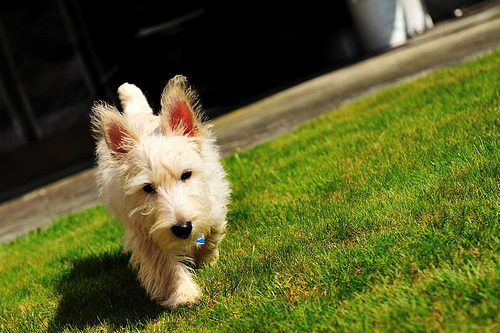

In [ ]:
PILImage.create(pets_files[0])

In [ ]:
m = PILImage.create(mnist_files[43000])

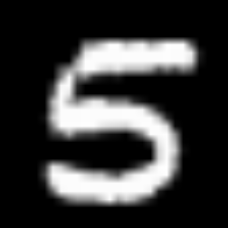

In [ ]:
n = Resize(228)(m)
n

In [ ]:
class RandomPlacement(Transform):
    def __init__(self, outer_size):
        assert len(outer_size) == 2
        self.outer_size = outer_size
    def encodes(self, i:TensorImage):
        return self._encodes( i.permute(1,2,0))
    def encodes(self, i:PILImage):
        return self._encodes(i)
    def _encodes(self, image):
        img = np.array(image)
        ims = np.array(img.shape)
        i_r, i_c = ims[:2]
        if self.outer_size[0]<ims[0] or self.outer_size[1]<ims[1]: return image
        ims[:2]=np.array(self.outer_size)
        outer_image = np.zeros(ims)
        ( o_r, o_c) = self.outer_size
        rr = random.randint(0,o_r-i_r)
        rc= random.randint(0,o_c-i_c)
        outer_image[rr:rr+i_r, rc:rc+i_c]=img/255
        return TensorImage(outer_image)  

In [ ]:
x =RandomPlacement((742, 1162))(PILImage.create(pets_files[42]))

bbbbbb


<AxesSubplot:>

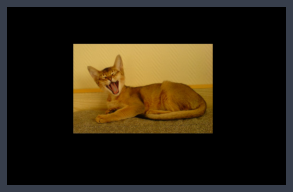

In [ ]:
x.show()

<AxesSubplot:>

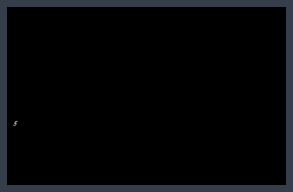

In [ ]:
RandomPlacement((742, 1162))(PILImage.create(mnist_files[42421])).show()

<AxesSubplot:>

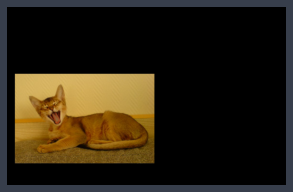

In [ ]:
RandomPlacement((742, 1162))(ToTensor()(PILImage.create(pets_files[42]))).show()

In [ ]:
class RandomResize(Transform):
    def __init__(self, min_sz, max_sz):
        self.min_sz, self.max_sz = min_sz, max_sz
    def encodes(self, image):
        sz = random.randint(self.min_sz,self.max_sz)
        return RatioResize(sz)(image)

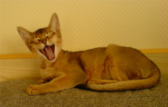

In [ ]:
RandomResize(128,224)(PILImage.create(pets_files[42]))

<AxesSubplot:>

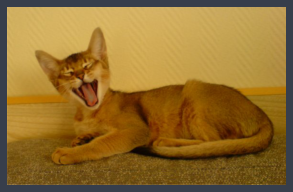

In [ ]:
RandomResize(128,224)(ToTensor()(PILImage.create(pets_files[42]))).show()

In [ ]:
class OcclusionTransform(Transform):
    def __init__(self, occlusion_files):
        self.occ_fns = occlusion_files    
    def encodes(self, f):
        o = random.choice(self.occ_fns)
        i_pipe = Pipeline([PILImage.create, Resize(224)])
        i = i_pipe(f)
        r, c = i.shape
        s = min(r,c) 
        pipe = Pipeline([PILImage.create, RandomResize(int(s*0.4), int(s*.9)), RandomPlacement((r,c))])
        o_img =Tensor.float(pipe(o))
        mask = o_img[:,:]>0.2
#         o_img = o_img.unsqueeze( 2)  only for PILMask, will do later
        color = get_mean_color(i)
#         o_img *= color #applying the mean color to the occlusion
        o_img = mask * color
        b_img = Tensor.float(ToTensor()(i)).permute(1,2,0)/255
        mask = o_img[:,:]==0
        o_img[mask]=b_img[mask]
        return (TensorImage(o_img), 

<AxesSubplot:>

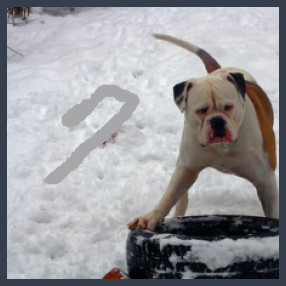

In [ ]:
f = random.choice(pets_files)
ot = OcclusionTransform(mnist_files)
o=ot(f)
o.show()

(<AxesSubplot:>, torch.Size([300, 271, 3]))

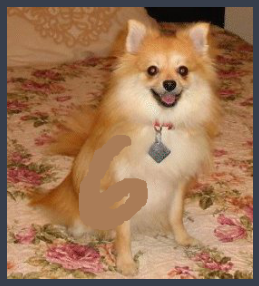

In [ ]:
p = Resize(224)(o)
p.show(), p.shape

In [ ]:
tl= TfmdLists(pets_files,OcclusionTransform(mnist_files))

In [ ]:
dls = DataLoaders.from_dsets(tl,tl)
dls = dls.cuda()

In [ ]:
dls.show_batch()

TypeError: object of type 'NoneType' has no len()

In [ ]:
splits = RandomSplitter()(pets_files[:1000])
tfm = OcclusionTransform(mnist_files)
tls = TfmdLists(pets_files[:1000], tfm, splits=splits)
dls = tls.dataloaders()
#     after_item=[Resize(224), ToTensor], 
#                       after_batch=[])
#                       after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls.one_batch()

RuntimeError: stack expects each tensor to be equal size, but got [375, 500, 3] at entry 0 and [500, 333, 3] at entry 1